In [1]:
from tqdm import tqdm
import glob
import numpy as np
import multiprocessing as mp
from uuid import UUID
import lz4
from typing import List, Tuple, Dict, Union, Optional, Iterable
from joblib import Parallel, delayed

from pit30m.data.partitions import PreProcessPartition, GeoPartition, QueryBasePartition
from pit30m.camera import CamName
from pit30m import LogReader

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
with open("../pit30m/all_logs.txt", "r") as f:
    logs = f.readlines()
    logs = sorted([x.strip() for x in logs])

# logs = []
# for f in glob.glob("/home/julieta/pit30m_partitions/utm_poses_dense/to_hide/*"):
# print(logs)
#     logs.append(f.split("/")[-1][:-4])

logs = logs[:50]
print(logs)

['00682fa6-2183-4a0d-dcfe-bc38c448090f', '006ce26a-cd92-4b90-ec10-454da73ede13', '009334fa-acb9-4813-c60c-1916c83974c8', '00a05077-a8f6-4f08-ee38-c7bc4e885611', '0106abc2-b689-464a-cfe4-9f6a00089733', '017be362-c6cf-47fe-e317-fdcf128ce85a', '01959149-0840-4eba-e0a0-53c6b2bb0f84', '01c3ae4e-2bb6-4bd1-efc9-bfb16e4bd1e3', '01d09d4c-329a-4952-f2ed-555aa76dab2c', '01e21524-2e61-4ea6-cf98-164bcb2d29ab', '01e86404-c224-4b10-d12e-9e2144626b3b', '020465aa-b3f0-4b8e-c6af-b535078fe30c', '020829cb-e2a3-4160-df19-8bd4682f1115', '0209f084-2efb-4acf-f2ce-e8f8a58c8b06', '021286dc-5fe5-445f-e5fa-f875f2eb3c57', '024e8e83-7778-496f-e3c4-dfd7c0875d2d', '025c3909-7fe4-4817-e386-5d2de975363a', '025e793e-e8eb-4c6d-e074-accb77dbe4d3', '027a633e-c9d0-4340-fa28-50bf842e6d2c', '0281c09f-836a-4cfa-dcbd-77f1349b6b96', '0308a5d9-6e4c-498f-e7ef-c75e8ae721af', '0330dec6-1dbe-44d8-e139-723f2b7be005', '03359966-92d2-44d5-df29-3f391645f9ab', '03709ebf-bcce-43c5-dd63-9170b2a74836', '037e11f7-2300-47ad-e41d-9d87c2ec218f',

In [3]:
def maybe_get_sensor_index(log_reader: LogReader, sensor: str, partitions=None) -> Tuple[str, Optional[np.ndarray]]:
    """Try to fetch index from AWS, return None if it doesn't exist"""    
    try:
        if sensor == "LIDAR":
            index = log_reader.get_lidar_geo_index()
        elif sensor in CamName.__members__:
            index = log_reader.get_cam_geo_index(CamName[sensor.upper()], max_delta_s=0.2, partitions=partitions)
        else:
            raise ValueError(f"Unknown sensor {sensor}")
    except FileNotFoundError:
        index = None
    
    return log_reader.log_id, index
    

def get_sensor_indices(
    log_readers: Iterable[LogReader], sensor: str, partitions = None, 
) -> Tuple[Dict[UUID, np.ndarray], Dict[UUID, LogReader], Parallel]:
    """Get the indices that map poses to sensor observations"""
    pool = Parallel(n_jobs=mp.cpu_count(), verbose=1, batch_size=8)
    res = pool(delayed(maybe_get_sensor_index)(lr, sensor, partitions) for lr in log_readers)
    sensor_indices = {log_id: index for (log_id, index) in res}
    # log_readers = {log_id: lr for (log_id, lr) in zip(logs, log_readers)}
    return sensor_indices, pool

In [4]:
log_readers = {}
for logid in logs:
    # log_readers[logid] = LogReader(f"s3://pit30m/{logid}/", index_version=1)
    log_readers[logid] = LogReader(
        f"s3://pit30m/{logid}/", 
        index_version=2, 
        # partitions=[PreProcessPartition.VALID, GeoPartition.TRAIN],
        # partitions=[PreProcessPartition.VALID, GeoPartition.TEST, QueryBasePartition.QUERY],
    )

[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


/home/julieta/miniconda3/envs/pit30m/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[Parallel(n_jobs=16)]: Done  50 out of  50 | elapsed:   34.7s finished


100%|██████████| 50/50 [00:00<00:00, 568.51it/s]

12_245 poses included so far
12_245 poses included so far
12_245 poses included so far
46_577 poses included so far
58_485 poses included so far
87_455 poses included so far
122_277 poses included so far
122_277 poses included so far
134_052 poses included so far
163_815 poses included so far
192_909 poses included so far
192_909 poses included so far
212_654 poses included so far
226_153 poses included so far
236_999 poses included so far
263_123 poses included so far
284_917 poses included so far
312_591 poses included so far
378_566 poses included so far
395_373 poses included so far
411_939 poses included so far
411_939 poses included so far
431_724 poses included so far
449_380 poses included so far
456_126 poses included so far
456_126 poses included so far
483_078 poses included so far
483_078 poses included so far
493_630 poses included so far
514_179 poses included so far
528_589 poses included so far
589_547 poses included so far
589_547 poses included so far
605_606 poses in

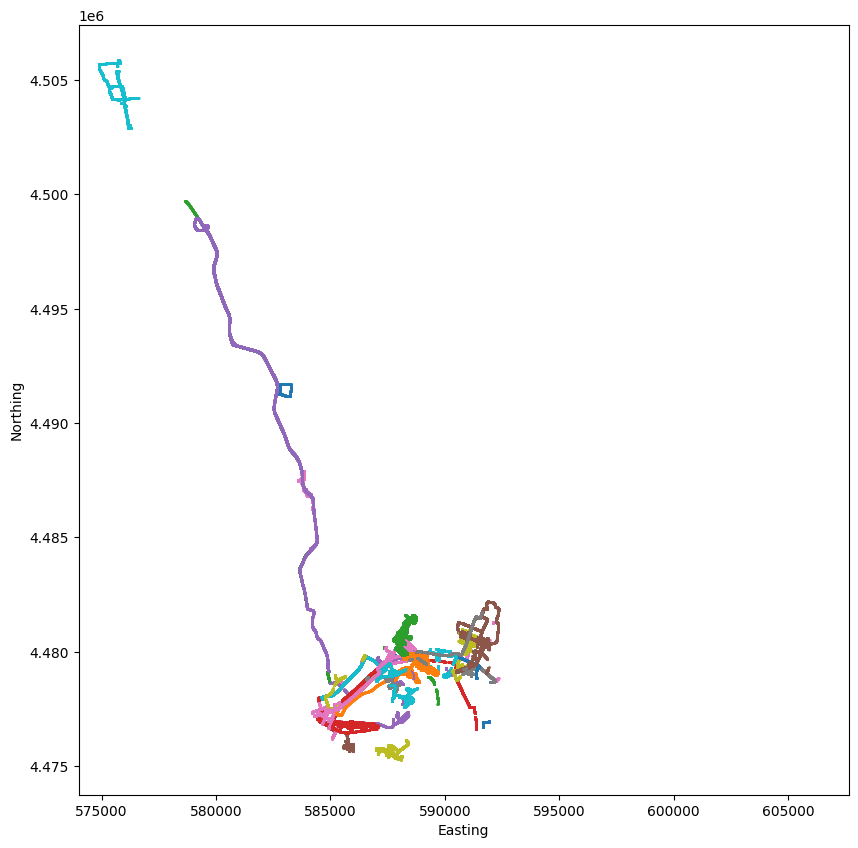

In [5]:
figsz = 20 // 2
fig = plt.figure(figsize=(figsz, figsz), dpi=100, facecolor='w', edgecolor='k')

included = 0
with_poses = []
missing = []

# Load all the indices asynchronously
sensor_indices, pool = get_sensor_indices(
    log_readers.values(), 
    CamName.MIDDLE_FRONT_WIDE.name, 
    partitions=[PreProcessPartition.VALID, GeoPartition.TRAIN],
)

for log_id, index in tqdm(sensor_indices.items()):

    # if log_id == "017be362-c6cf-47fe-e317-fdcf128ce85a":
    #     continue
    # if log_id == "01959149-0840-4eba-e0a0-53c6b2bb0f84":
    #     continue
    
    # camera index
    if index is None:
        print(f"{log_id} has no index yet")
        missing.append(log_id)
        continue
    
    utm_present = index["utm_present"]
    x = index["utm_x"][utm_present]
    y = index["utm_y"][utm_present]
    
    # # UTM poses with offsets from the maps 
    # valid, xyzs = lr.utm_poses_dense
    # xyzs = xyzs[valid]
    # x, y = xyzs[:, 0], xyzs[:, 1]
    # if len(x) > 0:
    #     print(xyzs[0])
    
    # This gives me 3_249 poses
    # pose_index = lr.continuous_pose_dense
    # x, y = pose_index[:, 2], pose_index[:, 3]
    
    # MRP dense, removing invalid, I get 2_530 poses
    # pose_index = lr.map_relative_poses_dense
    # pose_index = pose_index[pose_index["valid"]]
    # x, y = pose_index["x"], pose_index["y"]
     
    sc = plt.scatter(x, y, s=0.5, alpha=0.5)
    
    # if len(x) > 0:
    #     print(log_id, pose_index[0])
    #     print(pose_index["time"][0])
    #     with_poses.append(log_id)
    
    included += len(x)
    print(f"{included:_} poses included so far")
    
    # percent_hidden = 100 * hidden_in_log / len(utm)
    # if percent_hidden > 90: 
    #     print(f"{log_id} has {hidden_in_log:_} poses to hide ({percent_hidden:.2f}%)")

plt.axis("square")
plt.xlabel("Easting")
plt.ylabel("Northing")
print(f"Total included: {included:_}")
print(f"Total with poses: {len(with_poses)}")
print(with_poses)
print(missing)

In [ ]:
submap_ids = sorted([UUID(bytes=x.ljust(16, b"\x00")) for x in np.unique(index["submap_id"])])
print(len(submap_ids))
print(submap_ids[:10])

NameError: name 'index' is not defined

In [ ]:
from typing import Iterable
from pathlib import Path
from joblib import Parallel, delayed
import pickle
from numpy.lib import recfunctions as rfn

def get_utm_poses_with_metadata(lr):
    pose_time, pose_valid, pose_xy = lr.utm_poses_dense
    time = rfn.unstructured_to_structured(pose_time[:, np.newaxis], names=["utm_time"])
    # assert np.all(np.diff(time["utm_time"]) >= 0), "Pose times are not sorted"
    valid = rfn.unstructured_to_structured(pose_valid[:, np.newaxis], names=["utm_valid"])
    # assert len(valid) == len(pose_valid)
    xys = rfn.unstructured_to_structured(pose_xy, names=["utm_x", "utm_y"])
    # assert len(xys) == len(pose_xy)
    sensor_poses = rfn.merge_arrays([time, valid, xys], flatten=True)

    return lr.log_id, sensor_poses

def get_utm_dense_poses(
    logs: Iterable[UUID],
    logreader_path: Path = Path("/mnt/data/pit30m/pose-backup-2023-04-18/"),
    # logreader_path: Path = Path("/mnt/data/pit30m/pose-backup-2023-04-18/"),
    pool: Parallel = None,
    pickled: bool = None,
):
    """Multiple ways to get dense poses
    Args:
        logs: list of log ids whose dense poses we want to load
        logreader_path: Path where to load log readers from
        pool: pool of parallel workers to load the poses
        pickled: whether to load from a pre-dumped pickled file on disk
    """

    log_readers = [LogReader(str(logreader_path / f"{log}")) for log in logs]

    if pickled:
        # If loading from pickle, ignore everything and just load from disk
        with open("/home/julieta/pickles/utm_dense_poses.pkl", "rb") as handle:
            sensor_poses = pickle.load(handle)

        # The pickle has everything -- filter for the ones that were asked for
        sensor_poses = {log_id: sensor_pose for (log_id, sensor_pose) in sensor_poses.items() if log_id in logs}
    else:
        if pool:
            res = pool(delayed(get_utm_poses_with_metadata)(lr) for lr in log_readers)
            sensor_poses = {log_id: index for (log_id, index) in res}
        else:
            sensor_poses = {
                log_id: get_utm_poses_with_metadata(lr)[1]
                for (log_id, lr) in tqdm(
                    zip(logs, log_readers), total=len(logs), desc="Getting dense poses sequentially from disk"
                )
            }

    log_readers = {log_id: lr for (log_id, lr) in zip(logs, log_readers)}
    return sensor_poses, log_readers, pool


In [ ]:
pose_fpath = "/mnt/data/pit30m/pose-backup-2023-04-18/556af30b-cb04-4a08-ee47-4eb9e79da376/all_poses.npz.lz4"

In [ ]:
with open(pose_fpath, "rb") as in_compressed_f:
    with lz4.frame.open(in_compressed_f, "rb") as wgs84_f:
        poses = np.load(wgs84_f)["data"]

In [ ]:
submap_ids = sorted([UUID(bytes=x.ljust(16, b"\x00")) for x in np.unique(poses["map_relative"]["submap"])])
print(len(submap_ids))
print(submap_ids[:10])

136
[UUID('00a53038-3072-4115-f458-02769036233f'), UUID('02c07a67-6925-4d5e-c4e4-3a65b1e37b94'), UUID('07e78e05-8aba-421f-e1e4-27679cec69a7'), UUID('082c2a5a-7516-4f9e-fce0-6ab6eb3e0965'), UUID('0c40dc7d-1d68-4482-d48a-d3c71ff26ca4'), UUID('0cd730f5-08b5-4a91-e5c2-077134e3cb61'), UUID('0d864017-a690-4255-c225-551e3c48705f'), UUID('116570b4-6598-4c1a-da4f-948194f9d04b'), UUID('12e48274-21e0-4340-d3fa-101b21a1baab'), UUID('17b09d4c-2514-43c8-f3e3-8133a4ebc62e')]
